In [73]:
import functools
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import multiprocessing
import seaborn as sns
import warnings

from lightgbm import LGBMRegressor

from skforecast.preprocessing import RollingFeatures, series_long_to_dict
from scipy.stats import f_oneway
from statsmodels.tsa.seasonal import STL
from mpire import WorkerPool

from skforecast.recursive import ForecasterRecursive, ForecasterRecursiveMultiSeries
from skforecast.direct import ForecasterDirect

In [59]:
NUM_CPU_CORES = multiprocessing.cpu_count()
LAGS = 14
FORECAST_PERIOD = 14
TARGET_COL = 'demand'
RANDOM_SEED = 1234

In [3]:
!pwd

/Users/alanchn31/Desktop/coupang_prep


In [4]:
df = pd.read_csv("data/demand_forecasting_dataset_large.csv")

In [5]:
# Random assign null values 

rand_missing_idx = np.random.randint(0, len(df), 10)

for idx in rand_missing_idx:
    df.loc[idx, 'demand'] = np.nan

In [6]:
def summarize_df(df):
    print("% of null values in each column")
    print(df.isnull().sum() / len(df)*100)

summarize_df(df)

% of null values in each column
date             0.000000
sku_id           0.000000
category         0.000000
region           0.000000
price            0.000000
promo_flag       0.000000
stockout_flag    0.000000
demand           0.013889
dtype: float64


In [7]:
def forward_fill_col(df, idx_cols, ffill_col):
    df[ffill_col] = df.groupby(idx_cols)[ffill_col].ffill()
    return df

In [8]:
df2 = forward_fill_col(df,['sku_id', 'category', 'region'] , 'demand')

In [9]:
def week_of_month(df):
    df['week_of_month'] = pd.to_numeric(df['date'].dt.day/7)
    df['week_of_month'] = df['week_of_month'].apply(lambda x: math.ceil(x))
    return df

def day_of_week(df):
    df['day_of_week'] = df['date'].dt.day_name()
    return df

def gen_seasonal_feats(df):
    df = week_of_month(df)
    df = day_of_week(df)
    return df

In [10]:
df['date'] = pd.to_datetime(df['date'])

In [11]:
df = gen_seasonal_feats(df)

In [12]:
def calc_seasonal_strength(item_id, df_sub, period=7):
    ts = df_sub['demand']
    stl = STL(ts, period=period, robust=True)
    result = stl.fit()
    seasonal_strength = max(0, 1-np.var(result.seasonal) / (np.var(result.seasonal) + np.var(result.resid)))
    seas_df = pd.DataFrame({
        'item_id': [item_id],
        'seas_strength': [seasonal_strength]})
    return seas_df

def test_week_of_month_seasonality(item_id, df_sub):
    # Using F-test to check for deterministic seasonality
    groups = [group['demand'].values for _, group in df_sub.groupby('week_of_month')]
    ht_df = pd.DataFrame({
        'item_id': [item_id],
        'pvalue': [f_oneway(*groups).pvalue]})
    return ht_df

In [13]:
df['item_id'] = df[['sku_id', 'category', 'region']].apply(lambda x: '_'.join(x), axis=1)

seasonality_measure = functools.partial(calc_seasonal_strength,
                                        period=7)

with WorkerPool(n_jobs=NUM_CPU_CORES) as pool:
    list_seas_measure= pool.map_unordered(seasonality_measure, df.groupby('item_id'), progress_bar=True)
    seas_result = pd.concat(list_seas_measure, axis=0)

seas_result.rename(columns={'seas_strength': 'day_of_week_seas'}, inplace=True)
df = df.merge(seas_result, on=['item_id'])
df.sort_values(by='day_of_week_seas', ascending=False).head(10)

100%|██████████| 400/400 [00:00<00:00, 1264.31it/s]


,date,sku_id,category,region,price,promo_flag,stockout_flag,demand,week_of_month,day_of_week,item_id,day_of_week_seas
20386,2024-02-16,SKU029,Health,South,5.23,0,0,29.0,3,Friday,SKU029_Health_South,0.854094
20406,2024-03-07,SKU029,Health,South,4.18,1,0,40.0,1,Thursday,SKU029_Health_South,0.854094
20404,2024-03-05,SKU029,Health,South,5.23,0,0,31.0,1,Tuesday,SKU029_Health_South,0.854094
20403,2024-03-04,SKU029,Health,South,5.23,0,0,20.0,1,Monday,SKU029_Health_South,0.854094
20402,2024-03-03,SKU029,Health,South,5.23,0,0,21.0,1,Sunday,SKU029_Health_South,0.854094
20401,2024-03-02,SKU029,Health,South,4.18,1,0,31.0,1,Saturday,SKU029_Health_South,0.854094
20400,2024-03-01,SKU029,Health,South,5.23,0,0,20.0,1,Friday,SKU029_Health_South,0.854094
20399,2024-02-29,SKU029,Health,South,5.23,0,0,24.0,5,Thursday,SKU029_Health_South,0.854094
20398,2024-02-28,SKU029,Health,South,5.23,0,0,29.0,4,Wednesday,SKU029_Health_South,0.854094
20397,2024-02-27,SKU029,Health,South,5.23,0,0,22.0,4,Tuesday,SKU029_Health_South,0.854094


In [14]:
wom_ht_measure = functools.partial(test_week_of_month_seasonality)

with WorkerPool(n_jobs=NUM_CPU_CORES) as pool:
    list_ht= pool.map_unordered(wom_ht_measure, df.groupby('item_id'), progress_bar=True)
    ht_result = pd.concat(list_ht, axis=0)

df = df.merge(ht_result, on=['item_id'])

100%|██████████| 400/400 [00:00<00:00, 2714.24it/s]


In [20]:
df.sort_values(by='pvalue').head(5)

,date,sku_id,category,region,price,promo_flag,stockout_flag,demand,week_of_month,day_of_week,item_id,day_of_week_seas,pvalue
9267,2024-03-28,SKU013,Health,West,48.53,1,0,23.0,4,Thursday,SKU013_Health_West,0.645892,0.003226
9238,2024-02-28,SKU013,Health,West,60.66,0,0,18.0,4,Wednesday,SKU013_Health_West,0.645892,0.003226
9237,2024-02-27,SKU013,Health,West,60.66,0,0,19.0,4,Tuesday,SKU013_Health_West,0.645892,0.003226
9236,2024-02-26,SKU013,Health,West,60.66,0,0,29.0,4,Monday,SKU013_Health_West,0.645892,0.003226
9235,2024-02-25,SKU013,Health,West,60.66,0,0,16.0,4,Sunday,SKU013_Health_West,0.645892,0.003226


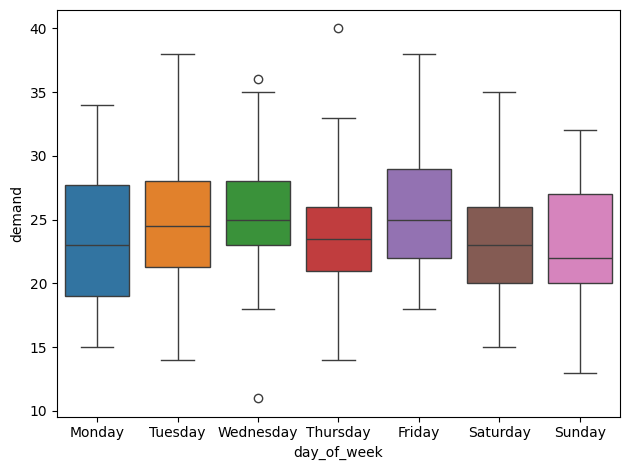

In [15]:
plt.figure()
sns.boxplot(x='day_of_week', y='demand', hue='day_of_week', data=df.query("item_id == 'SKU029_Health_South'"))
plt.tight_layout()

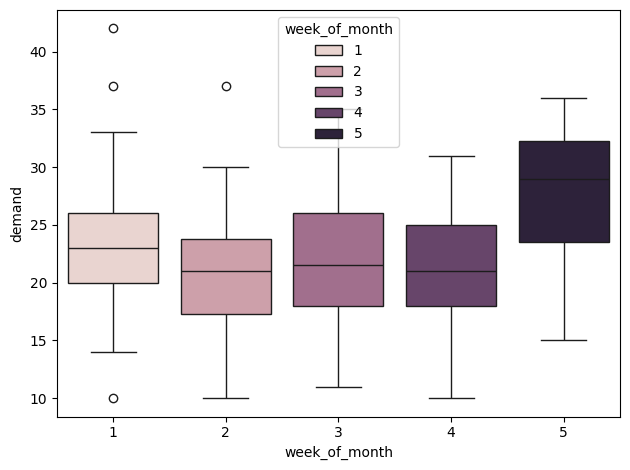

In [21]:
plt.figure()
sns.boxplot(x='week_of_month', y='demand', hue='week_of_month', data=df.query("item_id == 'SKU013_Health_West'"))
plt.tight_layout()

In [39]:
## Feature Engineering

def eng_rolling_features(predictors: list, window_sizes: list):
    '''
    From: https://skforecast.org/0.14.0/user_guides/window-features-and-custom-features.html#rollingfeatures
    'mean': the mean of the previous n values.
    'std': the standard deviation of the previous n values.
    'min': the minimum of the previous n values.
    'max': the maximum of the previous n values.
    'sum': the sum of the previous n values.
    'median': the median of the previous n values.
    'ratio_min_max': the ratio between the minimum and maximum of the previous n values.
    'coef_variation': the coefficient of variation of the previous n values.
    '''
    pred_expanded = []

    # Expand predictors to match window_size
    # For eg, 2 predictors, mean & median, with window_size 1,7,14
    # Expand predictors to match length of window size [mean,mean,mean,median,median,median]
    # with window_size: [1,7,14,1,7,14]
    for pred in predictors:
        pred_expanded += [pred]*len(window_sizes)
    
    window_size_expanded = window_sizes*len(predictors)

    print(f"predictors: {pred_expanded}")
    print(f"window size: {window_size_expanded}")

    return RollingFeatures(stats=pred_expanded, window_sizes=window_size_expanded)

In [40]:
# Features for time series forecasting
predictors = ['mean', 'median']
window_sizes = [1, 7, 14]
rolling_feats = eng_rolling_features(predictors, window_sizes)

predictors: ['mean', 'mean', 'mean', 'median', 'median', 'median']
window size: [1, 7, 14, 1, 7, 14]


In [60]:
def _local_lgbm_forecast(id, 
                         df, 
                         lags,
                         rolling_feats,
                         forecast_periods, 
                         forecast_mode, 
                         target_col='target_col',
                         exog_feats=None):
    # 1. Recursive Multi-step Local LGBM Forecaster
    if forecast_mode == 'recursive':
        forecaster = ForecasterRecursive(
                        regressor=LGBMRegressor(random_state=RANDOM_SEED, verbose=-1),
                        lags=lags,
                        window_features=rolling_feats
                    )
    # 2. Direct Multi-step Local LGBM Forecaster
    elif forecast_mode == 'direct':
        forecaster = ForecasterDirect(
                        regressor=LGBMRegressor(random_state=RANDOM_SEED, verbose=-1),
                        steps=forecast_periods,
                        lags=lags,
                        window_features=rolling_feats,
                    )
    if exog_feats:    
        forecaster.fit(y=df[target_col],
                       exog=df[exog_feats]
                       )
    else:
        forecaster.fit(y=df[target_col]
                       )
    pred = forecaster.predict(steps=forecast_periods)
    pred_df = pd.DataFrame({'forecast': pred})
    pred_df["item_id"] = id
    pred_df['date_key'] = pd.date_range(df['date'].max()+pd.Timedelta(days=1),
                                        df['date'].max()+pd.Timedelta(days=forecast_periods))
    return pred_df


def multi_threaded_local_lgbm_forecast(df, lags, rolling_feats, forecast_period, target_col, forecast_mode='recursive'):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model = functools.partial(_local_lgbm_forecast,
                                lags=lags,
                                rolling_feats=rolling_feats,
                                forecast_periods=forecast_period,
                                forecast_mode=forecast_mode,
                                target_col=target_col)
        with WorkerPool(n_jobs=NUM_CPU_CORES) as pool:
            list_forecast_lgbm = pool.map_unordered(model, df.groupby('item_id'), progress_bar=True)
        forecast_result_lgbm = pd.concat(list_forecast_lgbm, axis=0)
        return forecast_result_lgbm

In [61]:
local_recursive_forecasts = multi_threaded_local_lgbm_forecast(df, LAGS, rolling_feats, FORECAST_PERIOD, TARGET_COL)

100%|██████████| 400/400 [00:24<00:00, 20.23it/s]


In [65]:
local_direct_forecasts = multi_threaded_local_lgbm_forecast(df, LAGS, rolling_feats, FORECAST_PERIOD, TARGET_COL, forecast_mode='direct')

100%|██████████| 400/400 [04:44<00:00,  3.15it/s]


In [69]:
# Transform the sales dataFrame in "long format" and returns a dict of series.
series_dict = series_long_to_dict(
    data=df,
    series_id='item_id',
    index='date',
    values='demand',
    freq='D'
)

In [74]:
# Global LightGBM:
def global_lgbm_forecast(series_dict, rolling_feats, forecast_periods):
    # 1. Recursive Multi-series Global LGBM Forecaster
    forecaster = ForecasterRecursiveMultiSeries(
                    regressor=LGBMRegressor(random_state=RANDOM_SEED, verbose=-1),
                    lags=LAGS,
                    window_features=rolling_feats,
                    dropna_from_series=False
                )

    forecaster.fit(series=series_dict, suppress_warnings=True)
    forecasts_df = forecaster.predict(steps=forecast_periods)
    return forecasts_df

forecast_result_global_lgbm_recursive = global_lgbm_forecast(series_dict, rolling_feats, FORECAST_PERIOD)
forecast_result_global_lgbm_recursive.columns = ['forecast_' + c for c in forecast_result_global_lgbm_recursive.columns]
forecast_result_global_lgbm_recursive['date'] = forecast_result_global_lgbm_recursive.index
forecast_result_global_lgbm_recursive = pd.wide_to_long(forecast_result_global_lgbm_recursive, 
                                                        stubnames=['forecast_'], i="date", j="item_id",suffix='\w+')


/opt/anaconda3/envs/vn1/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/vn1/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/vn1/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/vn1/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/vn1/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will b

In [118]:
local_recursive_forecasts.to_csv("results/local_recursive_forecasts.csv", index=False)
local_direct_forecasts.to_csv("results/local_direct_forecasts.csv", index=False)
forecast_result_global_lgbm_recursive.to_csv("results/global_recursive_forecasts.csv", index=False)

In [119]:
def evaluate_wape(targets, predictions):
    '''
    Returns a WAPE value (Weighted Average Percentage Error)
        Parameters:
            1. targets: A numpy array containing target values
            2. predictions: A numpy array containing forecasts

        Returns:
            wape: WAPE of predictions vs targets
    '''
    resids_summed = np.sum(abs(targets-predictions))
    targets_summed = np.sum(targets)
    if targets_summed == 0:
        return np.nan
    wape = resids_summed/targets_summed
    return wape